# Used Cars Analysis Pipeline - PySpark
## 01. Data Profiling and Exploration (Spark Edition)

### Objectives:
1. Initialize Spark session for Windows
2. Load dataset into Spark DataFrame
3. Perform distributed data profiling
4. Identify quality issues using Spark SQL

In [1]:
import sys
import os
import findspark
import yaml
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.append(project_root)

config_path = os.path.join(project_root, 'config', 'pipeline_config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

hadoop_home = os.path.join(project_root, 'bin', 'winutils')
os.environ['HADOOP_HOME'] = hadoop_home
os.environ['PATH'] += os.pathsep + os.path.join(hadoop_home, 'bin')

findspark.init()

spark = SparkSession.builder \
    .appName("Profiling_PySpark") \
    .config("spark.driver.memory", config['spark']['driver_memory']) \
    .config("spark.executor.memory", config['spark']['executor_memory']) \
    .get_spark_session() if hasattr(SparkSession.builder, 'get_spark_session') else SparkSession.builder.getOrCreate()

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"✅ Spark Session started manually.")
print(f"✅ HADOOP_HOME set to: {hadoop_home}")

✅ Spark Session started manually.
✅ HADOOP_HOME set to: C:\Users\Administrator\Documents\Luxdev\used-cars-analysis-pipeline\bin\winutils


In [2]:
full_raw_path = os.path.join(project_root, 'data', 'raw')
dataset_filename = config['datasets']['superstore']['filename']
full_file_path = os.path.join(full_raw_path, dataset_filename)

print(f"🔍 Loading: {full_file_path}")

try:
    df_spark = spark.read.csv(
        full_file_path, 
        header=True, 
        inferSchema=True, 
        encoding='ISO-8859-1'
    )
    print(f"✅ Successfully loaded {df_spark.count():,} rows into Spark.")
    df_spark.show(5)
except Exception as e:
    print(f"❌ Spark load failed: {e}")


🔍 Loading: C:\Users\Administrator\Documents\Luxdev\used-cars-analysis-pipeline\data\raw\superstore_final_dataset.csv
✅ Successfully loaded 9,800 rows into Spark.
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+
|Row_ID|      Order_ID|Order_Date| Ship_Date|     Ship_Mode|Customer_ID|  Customer_Name|  Segment|      Country|           City|     State|Postal_Code|Region|     Product_ID|       Category|Sub_Category|        Product_Name|   Sales|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+
|     1|CA-2017-152156| 8/11/2017|11/11/2017|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentuc

In [3]:
if df_spark is not None:
    print("📊 Schema Information:")
    df_spark.printSchema()
    
    print("📋 First 5 rows:")
    df_spark.show(5, truncate=True)
    
    print("📈 Statistical Summary (Numeric):")
    df_spark.select([c for c, t in df_spark.dtypes if t in ['int', 'double']]).describe().show()

📊 Schema Information:
root
 |-- Row_ID: integer (nullable = true)
 |-- Order_ID: string (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Ship_Date: string (nullable = true)
 |-- Ship_Mode: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal_Code: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Sales: double (nullable = true)

📋 First 5 rows:
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+-

❌ Missing Values Analysis:
     Column  Missing_Count  Missing_Percentage
Postal_Code             11            0.112245


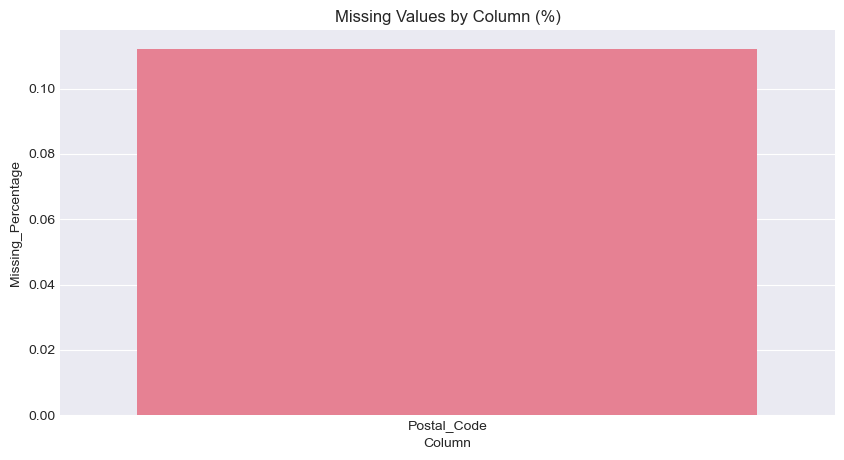

In [4]:
if df_spark is not None:
    print("❌ Missing Values Analysis:")
    total_rows = df_spark.count()
    
    missing_exprs = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]
    missing_counts = df_spark.agg(*missing_exprs).collect()[0].asDict()
    
    missing_data = []
    for col, count in missing_counts.items():
        if count > 0:
            missing_data.append({
                'Column': col, 
                'Missing_Count': count, 
                'Missing_Percentage': (count / total_rows) * 100
            })
    
    if missing_data:
        missing_df = pd.DataFrame(missing_data).sort_values('Missing_Percentage', ascending=False)
        print(missing_df.to_string(index=False))
        
        plt.figure(figsize=(10, 5))
        sns.barplot(data=missing_df, x='Column', y='Missing_Percentage')
        plt.title('Missing Values by Column (%)')
        plt.show()
    else:
        print("✅ No missing values found in the dataset.")

💰 Analyzing Sales Distribution...


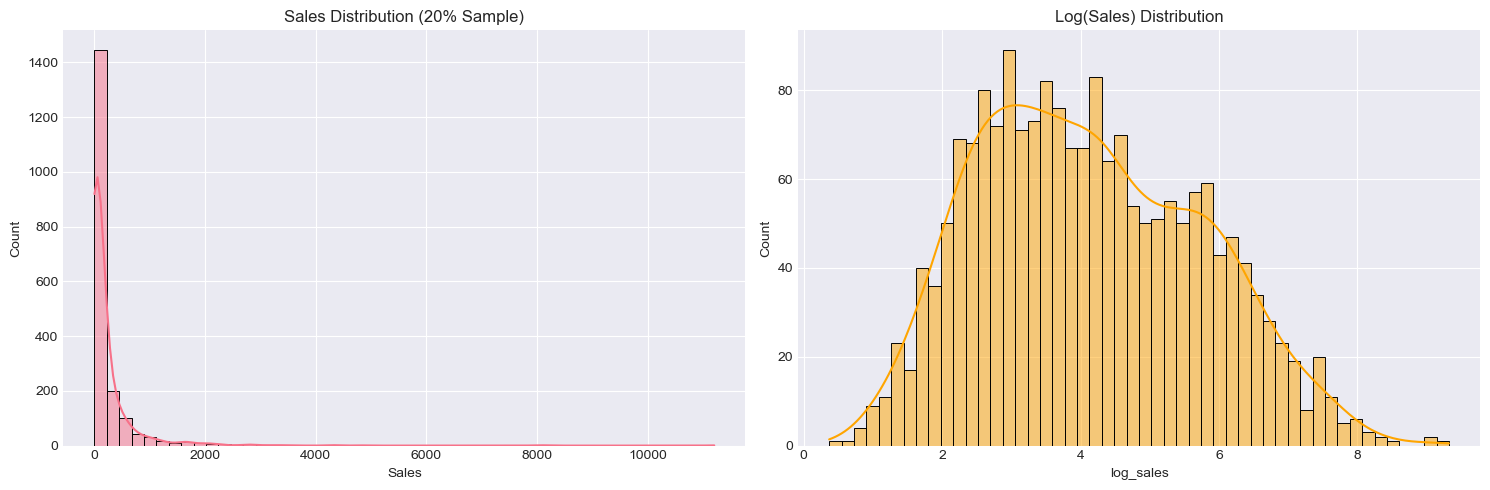

In [5]:
if df_spark is not None:
    target_col = 'Sales'
    
    print(f"💰 Analyzing {target_col} Distribution...")
    
    sample_pd = df_spark.select(target_col).sample(False, 0.2).toPandas()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(sample_pd[target_col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f'{target_col} Distribution (20% Sample)')
    
    sample_pd['log_sales'] = np.log1p(sample_pd[target_col])
    sns.histplot(sample_pd['log_sales'], bins=50, kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f'Log({target_col}) Distribution')
    
    plt.tight_layout()
    plt.show()


In [6]:
if df_spark is not None:
    total_count = df_spark.count()
    distinct_count = df_spark.distinct().count()
    duplicate_count = total_count - distinct_count
    
    print("\n" + "="*70)
    print("FINAL PROFILING SUMMARY")
    print("="*70)
    print(f"✅ Total Records: {total_count:,}")
    print(f"🔄 Duplicate Rows: {duplicate_count:,}")
    print(f"📊 Features: {len(df_spark.columns)}")
    print("="*70)



FINAL PROFILING SUMMARY
✅ Total Records: 9,800
🔄 Duplicate Rows: 0
📊 Features: 18
